<div class="alert alert-success">
<h1> SYNTACTIC PROCESSING - ASSIGNMENT</h1>

<h2>Submitted by: Praveersinh Parmar </h2>
</div>

<div class="alert alert-danger">
<h1> Identifying Entities in Healthcare Data</h1>
</div>


Tasks done in this notebook

1. Data preprocessing


2. Concept identification


3. Defining the features for CRF


4. Getting the features words and sentences


5. Defining input and target variables


6. Building the model


7. Evaluating the model


8. Identifying the diseases and predicted treatment using a custom NER

## Import and Install useful packages.

In [1]:
# Uncomment the below two lines of code if pycrf and sklearn-crfsuite are not installed
# !pip install pycrf
# !pip install sklearn-crfsuite

# Import libraries
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd
pd.set_option("display.max_colwidth", None) # Set display width option for a pandas dataframe
pd.set_option("display.max_rows", None) 
## Load the small English pipeline of spaCy
nlp = spacy.load("en_core_web_sm")

# `Task 1`: Data Preprocessing 🛠️

The dataset provided is in the form of one word per line. Let's understand the format of data below:

- Suppose there are **x** words in a sentence, then there will be **x** continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### 🗸  Construct proper sentences from individual words and print five sentences along with their labels.

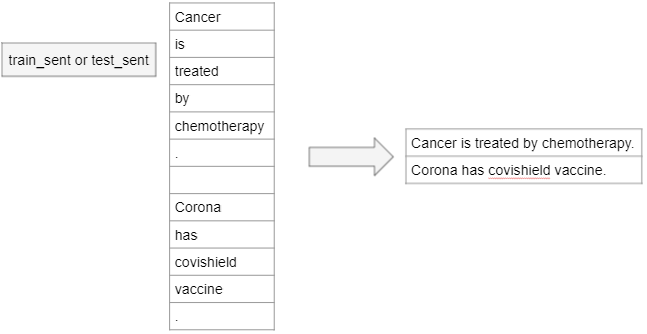

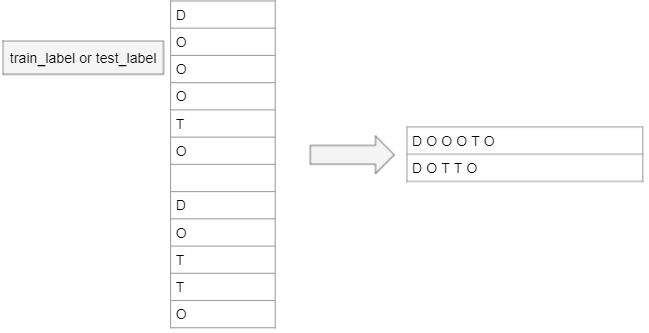

In [2]:
### Create a helper function to convert the given dataset of words to sentences

def words_to_sentences(words):
    '''Input: Data set containing individual words in separate lines
       Output: List containing sentences that are split by empty lines in given data'''
    
    # Split sentences by blank lines
    words = words.split("\n\n")
    out = []
    for sent in words:
        out.append([item.strip() for item in sent.split('\n')]) ## Create a list of lists containing words of sentences
    return [" ".join(i) for i in out]   # convert list of words to sentences

In [3]:
## Read the four given train and test files and convert them into sentences by splitting by empty lines
with open('train_sent', 'r') as train_sent_file:
    train_sent = train_sent_file.read()
train_sent = words_to_sentences(train_sent)    
    
with open('test_sent', 'r') as test_sent_file:
    test_sent = test_sent_file.read()
test_sent = words_to_sentences(test_sent) 
    
with open('train_label', 'r') as train_label_file:
    train_label = train_label_file.read()
train_label = words_to_sentences(train_label)    
    
with open('test_label', 'r') as test_label_file:
    test_label = test_label_file.read()
test_label = words_to_sentences(test_label)

In [4]:
train_sent[:2]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )']

In [4]:
## View five train sentences along with their labels

train_df = pd.DataFrame(columns=['Sentences', 'Labels'])   # Create empty dataframe
for i in range(len(train_sent)):
    train_df.loc[len(train_df)] = [train_sent[i], train_label[i]]   # Add two columns to dataframe, for setences and labels
train_df.sample(5)  # View five random train sentences and their labels


,Sentences,Labels
448,"CONCLUSION : In this series , PCCC with anterior vitrectomy was the only effective method of preventing or delaying secondary cataract formation in infants and children",O O O O O O T T T T O O O O O O O O O D D D O O O O
577,Statistical significant association was found between B,O O O O O O O
358,"MAIN OUTCOME MEASURES : Adolescents ' willingness to disclose general information , willingness to disclose information about sensitive topics , intended honesty , and likelihood of return visits to the physician depicted in the scenario were assessed by anonymous written questionnaire",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
2053,extracorporeal photopheresis has evolved as a possible therapy for patients with acute nd chronic lung allograft rejection,T T O O O O O O O O O D D D D D D
1640,"Athens , Greece , December 6-9 , 1995",O O O O O O O O


In [5]:
## View five test senences along with their labels

test_df = pd.DataFrame(columns=['Sentences', 'Labels'])  # Create empty dataframe
for i in range(len(test_sent)):
    test_df.loc[len(test_df)] = [test_sent[i], test_label[i]]  # Add two columns to dataframe, for setences and labels
test_df.sample(5)   # View five random test sentences and their labels


,Sentences,Labels
729,Tissue adhesives -- revisited,O O O O
93,Very few autonomic tests have been done on pediatric patients thus far,O O O O O O O O O O O O
1032,"Field evaluation of the clinical effectiveness of vaccines against pertussis , measles , rubella and mumps : comments",O O O O O O O T O D D D D D D D O O
373,"However , these results have to be confirmed by larger trials , currently underway , before to consider that beta-blockade should definitely be incorporated in the treatment of heart failure",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
28,"DESIGN : A complete sequence analysis of the BRCA1 coding sequence and flanking intronic regions was performed in 798 women in a collaborative effort involving institutions from the United States , Italy , Germany , Finland , and Switzerland",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


### 🗸 Count the number of sentences in the processed train and test dataset 

In [6]:
## View the number of sentences in train and test data sets

print(f"Number of sentences in train_sent = {len(train_sent)}")
print(f"Number of sentences in test_sent = {len(test_sent)}")

Number of sentences in train_sent = 2600
Number of sentences in test_sent = 1057


### 🗸 Count the number of lines of labels in the processed train and test dataset.

In [7]:
## View the number of lines of labels in train and test data sets

print(f"Number of lines of labels in train_label = {len(train_label)}")
print(f"Number of lines of labels in test_label = {len(test_label)}")

Number of lines of labels in train_label = 2600
Number of lines of labels in test_label = 1057


# `Task 2`: Concept Identification 💡

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### 🗸 Identify all the words from the corpus that have a tag of NOUN or PROPN (nouns) and prepare a dictionary of their counts

In [8]:
## Extract tokens having PoS tag 'NOUN' or 'PROPN' from both training and test sentences and save them in one list 'nouns'
nouns = []

for sent in train_sent:
    doc = nlp(sent)
    for token in doc:
        if token.pos_=="NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_.lower())

for sent in test_sent:
    doc = nlp(sent)
    for token in doc:
        if token.pos_=="NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_.lower())
nouns   # View the list

['birth',
 'week',
 'university',
 'vermont',
 'delivery',
 'route',
 'indication',
 'age',
 'parity',
 'practice',
 'group',
 'risk',
 'status',
 'rate',
 '%',
 'rate',
 '%',
 'presentation',
 'indication',
 '%',
 'rate',
 'medicine',
 'patient',
 '%',
 'rate',
 '%',
 'arrest',
 'dilation',
 'indication',
 'subgroup',
 '%',
 'rate',
 'care',
 'hospital',
 'rate',
 'community',
 'hospital',
 'group',
 'age',
 'trimester',
 'fluid',
 'index',
 'afi',
 'status',
 'temperature',
 'increase',
 'decrease',
 'afi',
 'june',
 'august',
 'period',
 'heat',
 'woman',
 'singleton',
 'pregnancy',
 'week',
 'gestation',
 'testing',
 'afi',
 'determination',
 'temperature',
 'area',
 'a',
 '2-',
 '3-',
 'day',
 'mean',
 'temperature',
 'test',
 'date',
 'afi',
 'spearman',
 'rank',
 'correlation',
 'relationship',
 'account',
 'afi',
 'measure',
 'being',
 'study',
 'population',
 'woman',
 'diabetes',
 'screening',
 'woman',
 'clinic',
 'hadassah',
 'medical',
 'center',
 'year',
 'period',
 'woma

In [9]:
## Convert the list of nouns to a pandas series to obtain frequencies of each noun using value_counts() method
noun_series = pd.Series(nouns).value_counts()
noun_series

patient                          568
treatment                        316
%                                247
study                            236
cancer                           226
cell                             203
therapy                          182
effect                           181
disease                          170
group                            145
case                             132
lung                             120
gene                             112
result                           111
year                             105
rate                             103
chemotherapy                      91
use                               90
trial                             90
conclusion                        89
woman                             88
analysis                          86
protein                           82
response                          81
risk                              78
child                             77
mutation                          75
d

In [10]:
## Create a dictionary of counts/frequencies
count_dict = {}
for noun in nouns:
    count_dict[noun] = noun_series.loc[noun]
count_dict

{'birth': 10,
 'week': 48,
 'university': 8,
 'vermont': 1,
 'delivery': 24,
 'route': 3,
 'indication': 6,
 'age': 61,
 'parity': 4,
 'practice': 49,
 'group': 145,
 'risk': 78,
 'status': 17,
 'rate': 103,
 '%': 247,
 'presentation': 9,
 'medicine': 43,
 'patient': 568,
 'arrest': 6,
 'dilation': 4,
 'subgroup': 6,
 'care': 56,
 'hospital': 37,
 'community': 16,
 'trimester': 4,
 'fluid': 8,
 'index': 15,
 'afi': 7,
 'temperature': 11,
 'increase': 32,
 'decrease': 5,
 'june': 2,
 'august': 6,
 'period': 30,
 'heat': 5,
 'woman': 88,
 'singleton': 1,
 'pregnancy': 46,
 'gestation': 9,
 'testing': 24,
 'determination': 8,
 'area': 17,
 'a': 22,
 '2-': 2,
 '3-': 2,
 'day': 63,
 'mean': 5,
 'test': 35,
 'date': 3,
 'spearman': 1,
 'rank': 2,
 'correlation': 20,
 'relationship': 18,
 'account': 4,
 'measure': 8,
 'being': 2,
 'study': 236,
 'population': 37,
 'diabetes': 22,
 'screening': 14,
 'clinic': 11,
 'hadassah': 1,
 'medical': 6,
 'center': 12,
 'year': 105,
 'treatment': 316,
 '

### 🗸 Print the top 25 most frequently discussed concepts in the entire corpus

#### (i.e. The top 25 most common tokens with NOUN or PROPN PoS tags)

In [11]:
## Use pandas 'head()' method to obtain the top 25 most common tokens in given data
print(f"-----------------------------------------------------")
print(f"Top 25 Most Common Tokens with NOUN or PROPN PoS Tags")
print(f"-----------------------------------------------------")
noun_series.head(26)   # Taken 26 as '%' is by mistake considered by spaCy as Noun

-----------------------------------------------------
Top 25 Most Common Tokens with NOUN or PROPN PoS Tags
-----------------------------------------------------


patient         568
treatment       316
%               247
study           236
cancer          226
cell            203
therapy         182
effect          181
disease         170
group           145
case            132
lung            120
gene            112
result          111
year            105
rate            103
chemotherapy     91
use              90
trial            90
conclusion       89
woman            88
analysis         86
protein          82
response         81
risk             78
child            77
dtype: int64

#### 📌 The most discussed concept in the corpus is `patient`, followed by `treatment`, `study`, `cancer` and `cell`

# `Task 3`:  Defining features for CRF ✨

### 🗸 Define the features with the PoS tag as one of the features.  
### 🗸 While defining the features in which you have used the PoS tags, you also need to consider the preceding word of the current word. The use of the information of the preceding word makes the CRF model more accurate and exhaustive.  
### 🗸 Mark the beginning and the end words of a sentence correctly in the form of features.

📌 First we will define what features we will give to our model to learn

- **Feature-1** (‘`word.PoS`’): The Part-of-Speech tag of the current word.


- **Feature-2** (‘`word.lower`’): The current word in lowercase.


- **Feature-3** (‘`word[-3:]`’): The last three characters of the current word.


- **Feature-4** (‘`word[-2:]`’): The last two characters of the current word


- **Feature-5** (‘`word.isupper`’): Boolean value showing whether the current word is in uppercase or not.


- **Feature-6** (‘`word.isdigit`’): Boolean value showing whether the current word is a digit or not.


- **Feature-7** (‘`words.StartsWithCapital`’): Boolean value showing whether the current word starts with a capital letter or not.


- **Feature-8** (‘`prev_word.PoS`’): The Part-of-Speech tag of the previous word.


- **Feature-9** (‘`prev_word.lower`’): The previous word in lowercase.


- **Feature-10** (‘`prev_word[-3:]`’): The last three characters of the previous word.


- **Feature-11** (‘`prev_word[-2:]`’): The last two characters of the previous word


- **Feature-12** (‘`prev_word.isupper`’): Boolean value showing whether the previous word is in uppercase or not.


- **Feature-13** (‘`prev_word.isdigit`’): Boolean value showing whether the previous word is a digit or not.


- **Feature-14** (‘`prev_word.StartsWithCapital`’): Boolean value showing whether the previous word starts with a capital 
letter or not.


- **Feature-15** (‘`BEG’`): This feature will return ‘BEG’ if the current word is the first word of the sentence.


- **Feature-16** (‘`END`’): This feature will return ‘END’ if the current word is the last word of the sentence.

In [12]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(words_of_sentence, i, token_PoS_list):
    '''
    Parameters:
    'words_of_sentences': list of all words in a sentence
    'i' : position of the word in the above list 'words_of_sentences'
    'token_PoS_list': list of PoS tags of corresponding words in above list 'words_of_sentences'
    
    Returns:
    'features': a list of all the features of the word at ith position in the list 'words_of_sentences'
    
    '''
    word = words_of_sentence[i]

    features = [
        'word.PoS=' + token_PoS_list[i], # PoS tag of the word
        'word.lower=' + word.lower(),    # word in lower case
        'word[-3:]=' + word[-3:],        # last three characters
        'word[-2:]=' + word[-2:],        # last two characters
        'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),  # is the word a number
        'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
      ]
        
    if(i > 0):
            prev_word = words_of_sentence[i-1]
            features.extend([
                'prev_word.PoS=' + token_PoS_list[i-1], # PoS tag of the previous word
                'prev_word.lower=' + prev_word.lower(), # previous word in lower case
                'prev_word[-3:]=' + prev_word[-3:],        # last three characters of previous word
                'prev_word[-2:]=' + prev_word[-2:],        # last two characters of previous word
                'prev_word.isupper=%s' % prev_word.isupper(), # is the previous word in all uppercase
                'prev_word.isdigit=%s' % prev_word.isdigit(), # is the previous word a number
                'prev_words.startsWithCapital=%s' % prev_word[0].isupper() # is the previous word starting with a capital letter
      ])
        
    else:
            features.append('BEG') # feature to track begin of sentence 
        
        
    if(i == len(words_of_sentence)-1):
            features.append('END') # feature to track end of sentence
        
    return features

# `Task 4`: Getting the features and the labels of sentences  🌟 🏷️

### 🗸 Write the code/function to get the features' value of a sentence after defining the features in the previous step.  


In [13]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    doc = nlp(sentence)
    token_PoS_list = [tok.pos_ for tok in doc]
    words_of_sentence = sentence.split()
    return [getFeaturesForOneWord(words_of_sentence, i, token_PoS_list) for i in range(len(words_of_sentence))]

### 🗸 Write the code/function to get a list of labels of a given preprocessed label line that you have created earlier.

In [14]:
# Write a code to get labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

# `Task 5`: Defining input and target variables 🎯

### 🗸 Extract the features' values for each sentence as an input variable for the CRF model in the test and the train dataset. 

In [15]:
## Extract features from training and test data
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

In [16]:
# View first row of training features
X_train[:1]

[[['word.PoS=DET',
   'word.lower=all',
   'word[-3:]=All',
   'word[-2:]=ll',
   'word.isupper=False',
   'word.isdigit=False',
   'words.startsWithCapital=True',
   'BEG'],
  ['word.PoS=ADJ',
   'word.lower=live',
   'word[-3:]=ive',
   'word[-2:]=ve',
   'word.isupper=False',
   'word.isdigit=False',
   'words.startsWithCapital=False',
   'prev_word.PoS=DET',
   'prev_word.lower=all',
   'prev_word[-3:]=All',
   'prev_word[-2:]=ll',
   'prev_word.isupper=False',
   'prev_word.isdigit=False',
   'prev_words.startsWithCapital=True'],
  ['word.PoS=NOUN',
   'word.lower=births',
   'word[-3:]=ths',
   'word[-2:]=hs',
   'word.isupper=False',
   'word.isdigit=False',
   'words.startsWithCapital=False',
   'prev_word.PoS=ADJ',
   'prev_word.lower=live',
   'prev_word[-3:]=ive',
   'prev_word[-2:]=ve',
   'prev_word.isupper=False',
   'prev_word.isdigit=False',
   'prev_words.startsWithCapital=False'],
  ['word.PoS=PUNCT',
   'word.lower=>',
   'word[-3:]=>',
   'word[-2:]=>',
   'word.isu

### 🗸 Extract the labels as the target variable for the test and the train dataset.

In [17]:
## Extract labels from training and test data
y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]
y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

In [27]:
# View first row of training labels
y_train[:1]

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

# `Task 6`: Building the CRF model 🏗️

### 🗸 You need to build the CRF model for a custom NER application using the features and the target variables.

In [18]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=1)

crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|█████████████████████████████████████████| 2600/2600 [00:00<00:00, 3561.76it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 26690
Seconds required: 0.299

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.09  loss=23286.86 active=26144 feature_norm=1.00
Iter 2   time=0.03  loss=22171.60 active=25291 feature_norm=0.89
Iter 3   time=0.03  loss=21241.26 active=25013 feature_norm=0.70
Iter 4   time=0.08  loss=20480.32 active=26459 feature_norm=0.79
Iter 5   time=0.05  loss=19042.80 active=26391 feature_norm=1.05
Iter 6   time=0.04  loss=16831.67 active=26543 feature_norm=1.38
Iter 7   time=0.02  loss=13844.90 active=26466 feature_norm=3.43
Iter 8   time=0.03  loss=13232.92 active=26501 feature_norm=3.52
Iter 9   time=0.05  loss=12590.53 active=26525 feature_norm=3.60
Iter 10  time=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100, verbose=1)

# `Task 7`: Evaluation ☑️

### 🗸 Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [19]:
# Make predictions on test data
y_pred = crf.predict(X_test)

### 🗸 Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [20]:
# View the f1 score of our model
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.9213235148264189

#### 📌 So our CRF model has a pretty good F1 Score of 0.92

# `Task 8`: Identifying Diseases and Treatments using Custom NER 💊

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### 🗸 Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.  

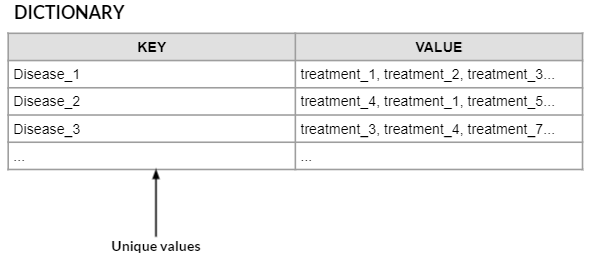

In [21]:
## First we extract indices of labels having values 'D' & 'T' in y_pred
indices_D = []
indices_T = []

for row in y_pred:
    indices_D.append([i for i, x in enumerate(row) if x == 'D'])
    indices_T.append([i for i, x in enumerate(row) if x == 'T'])

# View the list of indices
print(indices_D)
print('\n------------------------------------------------------\n')
print(indices_T)

[[], [], [], [], [], [11, 12, 13, 14, 15, 16], [], [], [], [], [], [], [10, 16, 17, 18], [12], [], [3, 4], [], [], [], [], [6, 7, 8], [0, 1, 2, 3, 20, 21, 22, 23], [], [], [], [], [], [16], [], [37, 38, 43, 44, 50, 51], [], [], [], [6, 7], [11, 12], [], [10, 11, 12], [19, 20], [], [14, 15, 16, 17, 18], [], [], [], [], [], [], [13, 17, 18], [], [], [], [], [], [], [10, 11], [], [13], [], [], [], [], [], [9, 11], [], [], [], [], [], [], [], [], [], [27, 28, 29, 30, 31, 32], [], [18, 19], [], [9, 10, 11], [], [], [], [], [], [], [], [], [], [], [], [], [6, 7], [8, 9], [], [], [], [], [], [], [], [], [], [], [33, 34], [], [], [22, 23, 24, 25, 30, 31], [], [12, 13, 14, 15], [], [], [], [4, 5], [], [34], [], [], [], [20, 21, 22, 23, 24, 25, 26, 27], [], [], [], [29, 30], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [0], [], [], [], [], [], [], [], [], [6, 7], [], [], [44], [], [11, 12], [], [5, 8, 9], [], [8, 9], [20, 21], [], [6, 7], [], [], [1

In [22]:
## Now we will use above indices_D to slice our test sentences to get names of Diseases

diseases = []

for i in range(len(indices_D)):
    lis_D = []
    for j in indices_D[i]:
        lis_D.append(test_sent[i].split()[j])
    diseases.append(lis_D)
diseases

[[],
 [],
 [],
 [],
 [],
 ['macrosomic', 'infants', 'in', 'gestational', 'diabetes', 'cases'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['microcephaly', 'nonimmune', 'hydrops', 'fetalis'],
 ['preeclampsia'],
 [],
 ['severe', 'preeclampsia'],
 [],
 [],
 [],
 [],
 ['asymmetric', 'double', 'hemiplegia'],
 ['A',
  'subchorial',
  'placental',
  'hematoma',
  'reversible',
  'nonimmune',
  'hydrops',
  'fetalis'],
 [],
 [],
 [],
 [],
 [],
 ['cancer'],
 [],
 ['breast', 'cancer', 'breast', 'cancer', 'ovarian', 'cancer'],
 [],
 [],
 [],
 ['prostate', 'cancer'],
 ['prostate', 'cancers'],
 [],
 ['hereditary', 'prostate', 'cancer'],
 ['prostate', 'cancer'],
 [],
 ['multiple', 'sclerosis', '(', 'MS', ')'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['cancer', 'hereditary', 'retinoblastoma'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['pericardial', 'effusions'],
 [],
 ['deafness'],
 [],
 [],
 [],
 [],
 [],
 ['epilepsy', 'ADHD'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['unstable', 'angina', 'or', 'non-Q-wave', 'myocardial',

In [23]:
## Next we will use above indices_T to slice our test sentences to get names of Treatments

treatments = []

for i in range(len(indices_T)):
    lis_T = []
    for k in indices_T[i]:
        lis_T.append(test_sent[i].split()[k])
    treatments.append(lis_T)
treatments

[[],
 [],
 [],
 [],
 [],
 ['good', 'glycemic', 'control'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Trisomy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['radiotherapy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['hearing', 'aids'],
 [],
 [],
 [],
 ['methylphenidate'],
 [],
 ['Methylphenidate'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['aspirin',
  ',',
  '3',
  'mg',
  'warfarin',
  'aspirin',
  ',',
  'or',
  '1',
  'mg',
  'warfarin',
  'aspirin'],
 ['warfarin', 'aspirin'],
 [],
 ['roxithromycin'],
 [],
 ['Antichlamydial', 'antibiotics'],
 ['surgery', 'radical', 'radiotherapy'],
 [],
 [],
 [],
 [],
 ['beta', 'human', 'chorionic', 'gondotropin'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['electrical', 'nerve', 'stimulation', '(', 'ENS', ')', 'therapy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['surg

In [24]:
## Create a dataframe containing Diseases and Treatments of each sentence in test data
final = pd.DataFrame({'Diseases': diseases, 'Treatments':treatments})
final

,Diseases,Treatments
0,[],[]
1,[],[]
2,[],[]
3,[],[]
4,[],[]
5,"[macrosomic, infants, in, gestational, diabetes, cases]","[good, glycemic, control]"
6,[],[]
7,[],[]
8,[],[]
9,[],[]


In [25]:
## The rows which contain one or both columns as empty list are of no use to us, so we remove them
final = final[(final['Diseases'].map(lambda d: len(d)) > 0)]
final = final[(final['Treatments'].map(lambda d: len(d)) > 0)]
final

,Diseases,Treatments
5,"[macrosomic, infants, in, gestational, diabetes, cases]","[good, glycemic, control]"
12,"[microcephaly, nonimmune, hydrops, fetalis]",[Trisomy]
46,"[cancer, hereditary, retinoblastoma]",[radiotherapy]
55,[deafness],"[hearing, aids]"
61,"[epilepsy, ADHD]",[Methylphenidate]
71,"[unstable, angina, or, non-Q-wave, myocardial, infarction]",[roxithromycin]
73,"[coronary-artery, disease]","[Antichlamydial, antibiotics]"
115,"[fenfluramines, to, primary, pulmonary, hypertension, (, PPH, )]",[fenfluramines]
119,"[essential, hypertension]",[moxonidine]
155,[cellulitis],"[G-CSF, therapy, intravenous, antibiotic, treatment]"


#### 📌 We have successfully extracted diseases from each test sentence and the corresponding predicted treatments

### 🗸 Predict the treatment for the disease named '`hereditary retinoblastoma`'.

In [26]:
## We look for words of given disease in 'Diseases' column and find the correspondings treatment
for row1, row2 in list(zip(final['Diseases'],final['Treatments'])):
    if ('hereditary' in row1 and 'retinoblastoma' in row1):
        print(row1, '-', row2)

['cancer', 'hereditary', 'retinoblastoma'] - ['radiotherapy']


#### 📌 The predicted treatment of `hereditary retinoblastoma` is `radiotherapy` as per our model